In [1]:
import numpy as np 
import pandas as pd
import glob
import plotly.express as px
import requests
import seaborn as sns


%load_ext autoreload
%autoreload 2

In [2]:
#load in data

df = pd.read_csv('../processed/caiso_merged_hourly_2019_2025_with_weather_and_solar_normalized.csv')

In [3]:
#import the load data: 
load_df = pd.read_csv('../raw/caiso_load_act_hr_2019_2025_hourly.csv')


In [4]:
load_df.tail()

Time          Load
56154  2025-05-29 02:00:00+00:00  28153.000000
56155  2025-05-29 03:00:00+00:00  28656.166667
56156  2025-05-29 04:00:00+00:00  28305.916667
56157  2025-05-29 05:00:00+00:00  26772.416667
56158  2025-05-29 06:00:00+00:00  24974.083333

In [5]:
px.line(load_df[:100], x='Time', y='Load', title='CAISO Load 2019-2025')

In [6]:
#now check that the start and end dates match
df['time'] = pd.to_datetime(df['time'])
load_df['Time'] = pd.to_datetime(load_df['Time'])

# Remove timezone info from load_df['Time'] to match df['time']
load_df['Time'] = load_df['Time'].dt.tz_localize(None)

print(df['time'].min(), df['time'].max())
print(load_df['Time'].min(), load_df['Time'].max())

#now restrict both to the most restrictive of these 
start_date = max(df['time'].min(), load_df['Time'].min())
end_date = min(df['time'].max(), load_df['Time'].max())
df = df[(df['time'] >= start_date) & (df['time'] <= end_date)]
load_df = load_df[(load_df['Time'] >= start_date) & (load_df['Time'] <= end_date)]


2019-01-01 00:00:00 2025-05-24 02:00:00
2019-01-01 08:00:00 2025-05-29 06:00:00


In [7]:
# Drop rows with NA in Load column and align both dataframes
load_df = load_df.dropna(subset=['Load'])
df = df[df['time'].isin(load_df['Time'])]
load_df = load_df[load_df['Time'].isin(df['time'])]

# Check that the number of rows match now
print(f"CAISO Data Rows after filtering: {len(df)}")
print(f"Load Data Rows after filtering: {len(load_df)}")
# Check that the time columns match
assert np.all(df['time'].values == load_df['Time'].values), "Time columns do not match after filtering"


CAISO Data Rows after filtering: 55970
Load Data Rows after filtering: 55970


In [8]:
#now we can build a model to predict load based on CAISO data
from sklearn.model_selection import train_test_split
#split the data into train and test sets
#can we include the time column in the features?

X = df.copy()
X['hour'] = X['time'].dt.hour
y = load_df['Load']

split_date = '2024-01-01'  # Define the split date

# Find the first index where hour is 0 and time is >= split_date using df (which still has 'time')
split_index = df[(X['hour'] == 0) & (df['time'] >= split_date)].index[0]

# Drop 'time' from X after finding split_index
X = X.drop(columns=['time'])

# Split the data into training and testing sets based on the split index
X_train = X[:split_index - 1]
X_test = X[split_index:]
y_train = y[:split_index - 1]
y_test = y[split_index:]


In [9]:
#compare sizes of train and test sets
print(f"Training set size: {len(X_train)}")
print(f"label set size: {len(y_train)}")
print(f"Testing set size: {len(X_test)}")
print(f"label set size: {len(y_test)}")
#now we can build a model to predict load based on CAISO data

Training set size: 43808
label set size: 43808
Testing set size: 12161
label set size: 12161


In [10]:
from sklearn.ensemble import RandomForestRegressor
#train a random forest regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
#predict on the test set
y_pred = rf.predict(X_test)
#calculate the mean absolute error
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")

Mean Absolute Error: 1212.0428931087279


In [11]:
import pandas as pd

# Prepare DataFrame for plotting
plot_df = y_test.to_frame(name='Actual Load').copy()
plot_df['Predicted Load'] = y_pred
plot_df['Time'] = load_df.loc[y_test.index, 'Time'].values

fig = px.line(
    plot_df.sort_values('Time'),
    x='Time',
    y=['Actual Load', 'Predicted Load'],
    title='Predicted vs Actual Load Over Time',
    labels={'value': 'Load', 'variable': 'Legend'}
)
fig.show()

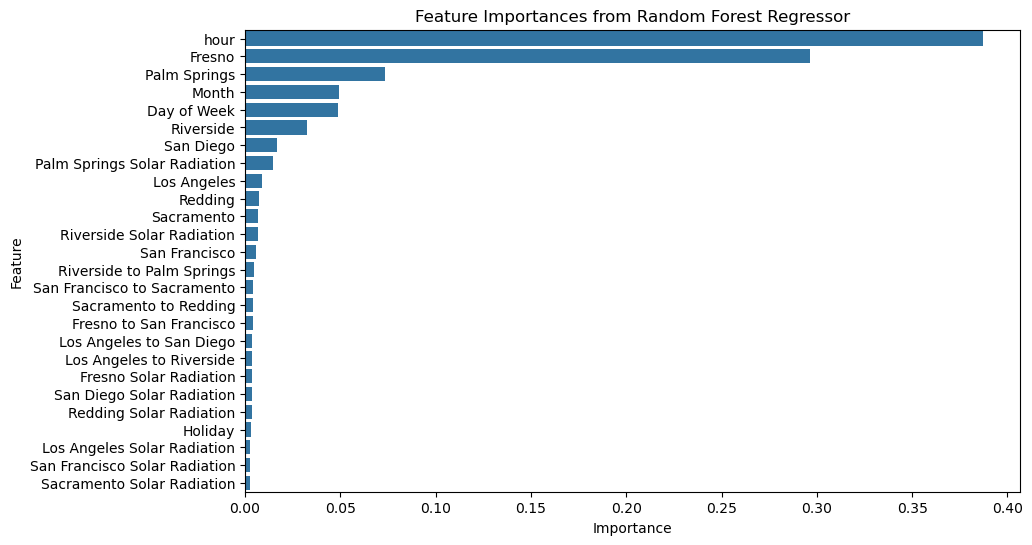

In [12]:
#show the feature importances
import matplotlib.pyplot as plt
importances = rf.feature_importances_
feature_names = X_train.columns
indices = np.argsort(importances)[::-1]
# Create a DataFrame for feature importances
feature_importances_df = pd.DataFrame({
    'Feature': feature_names[indices],
    'Importance': importances[indices]
})
# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances_df)
plt.title('Feature Importances from Random Forest Regressor')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [13]:
#let's try xgboost
import xgboost as xgb
# Convert the data to DMatrix format
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
# Set parameters for XGBoost
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'mae',
    'max_depth': 6,
    'eta': 0.1,
    'seed': 42
}
# Train the model
xgb_model = xgb.train(params, dtrain, num_boost_round=100)
# Predict on the test set
y_pred_xgb = xgb_model.predict(dtest)
# Calculate the mean absolute error
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
print(f"XGBoost Mean Absolute Error: {mae_xgb}")


XGBoost Mean Absolute Error: 1190.1063055970787


In [14]:
# Prepare DataFrame for plotting
plot_df_xgb = y_test.to_frame(name='Actual Load').copy()
plot_df_xgb['Predicted Load'] = y_pred_xgb
plot_df_xgb['Time'] = load_df.loc[y_test.index, 'Time'].values
fig_xgb = px.line(
    plot_df_xgb.sort_values('Time'),
    x='Time',
    y=['Actual Load', 'Predicted Load'],
    title='XGBoost Predicted vs Actual Load Over Time',
    labels={'value': 'Load', 'variable': 'Legend'}
)
fig_xgb.show()

In [15]:
#add lag variables to the data

#we have X with all features and y with the load
def add_lag_features(X, y, lags):
    """
    Add lag features to the dataset.
    
    Parameters:
    X (DataFrame): Features DataFrame.
    y (Series): Target variable.
    lags (list): List of lag periods to create features for.
    
    Returns:
    DataFrame: DataFrame with lag features added.
    """
    for lag in lags:
        X[f'Load_Lag_{lag}'] = y.shift(lag)
    return X

# Define the lags you want to add
lags = [1, 2, 3, 4, 5, 6, 12, 24]  # Example lags in hours
# Add lag features to the training and testing sets
X_train_lagged = add_lag_features(X_train.copy(), y_train, lags)
X_test_lagged = add_lag_features(X_test.copy(), y_test, lags)
# Drop rows with NaN values after adding lag features
X_train_lagged = X_train_lagged.dropna()
X_test_lagged = X_test_lagged.dropna()
# Ensure y_train and y_test are aligned with the lagged features
y_train_lagged = y_train.loc[X_train_lagged.index]
y_test_lagged = y_test.loc[X_test_lagged.index]

# make sure data has right sizes
print(f"Training set size with lags: {len(X_train_lagged)}")
print(f"label set size with lags: {len(y_train_lagged)}")
print(f"Testing set size with lags: {len(X_test_lagged)}")
print(f"label set size with lags: {len(y_test_lagged)}")

#nromalize the lagged features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Fit the scaler on the training data and transform both train and test sets
X_train_scaled = scaler.fit_transform(X_train_lagged)
X_test_scaled = scaler.transform(X_test_lagged)
# Convert back to DataFrame for easier handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train_lagged.columns, index=X_train_lagged.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test_lagged.columns, index=X_test_lagged.index)

y_train_scaled = scaler.fit_transform(y_train_lagged.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler.transform(y_test_lagged.values.reshape(-1, 1)).flatten()


    

Training set size with lags: 43770
label set size with lags: 43770
Testing set size with lags: 12110
label set size with lags: 12110


In [16]:
X_train_scaled.head()

Palm Springs   Redding  Sacramento  San Diego  Los Angeles    Fresno  \
24     -2.155820 -1.024157   -1.749959  -2.442217    -1.826741 -1.871183   
25     -2.048669 -1.004388   -1.772569  -2.442217    -1.950443 -1.920759   
26     -1.887942 -1.024157   -1.783875  -2.675572    -2.166923 -1.960420   
27     -1.909372 -1.093352   -1.817791  -2.845285    -2.135998 -1.990166   
28     -2.016523 -1.202085   -1.817791  -3.142282    -2.259700 -1.990166   

    San Francisco  Riverside  San Francisco to Sacramento  \
24      -1.017768  -1.845838                    -1.909903   
25      -0.733895  -1.908903                    -2.102598   
26      -1.386803  -1.997195                    -1.749323   
27      -2.039711  -2.009808                    -1.428165   
28      -2.238422  -1.719706                    -1.315759   

    Sacramento to Redding  ...  Fresno Solar Radiation      hour  Load_Lag_1  \
24               1.399010  ...               -0.733646 -1.661092   -0.487757   
25               1.508344  ...               -0.733646 -1.516644   -0.723573   
26               1.481010  ...               -0.733646 -1.372197   -0.873339   
27               1.371676  ...               -0.733646 -1.227749   -0.949241   
28               1.071006  ...               -0.733646 -1.083301   -0.934677   

    Load_Lag_2  Load_Lag_3  Load_Lag_4  Load_Lag_5  Load_Lag_6  Load_Lag_12  \
24   -0.168008    0.141693    0.325930    0.403242    0.436302    -1.263218   
25   -0.487730   -0.167997    0.141684    0.325904    0.403203    -1.257878   
26   -0.723543   -0.487716   -0.168007    0.141656    0.325863    -1.139078   
27   -0.873307   -0.723526   -0.487725   -0.168037    0.141610    -0.903462   
28   -0.949207   -0.873288   -0.723536   -0.487759   -0.168091    -0.442072   

    Load_Lag_24  
24    -0.594898  
25    -0.749294  
26    -0.873397  
27    -0.944853  
28    -0.945487  

[5 rows x 34 columns]

In [17]:
#now we can build a model to predict load based on CAISO data with lag features
#use xgboost again
dtrain_lagged = xgb.DMatrix(X_train_scaled, label=y_train_scaled)
dtest_lagged = xgb.DMatrix(X_test_scaled, label=y_test_scaled)
# Train the model with lag features
xgb_model_lagged = xgb.train(params, dtrain_lagged, num_boost_round=100)
# Predict on the test set with lag features
y_pred_xgb_lagged = xgb_model_lagged.predict(dtest_lagged)
# Calculate the mean absolute error with lag features
mae_xgb_lagged = mean_absolute_error(y_test_scaled, y_pred_xgb_lagged)
print(f"XGBoost with Lag Features Mean Absolute Error: {mae_xgb_lagged}")


XGBoost with Lag Features Mean Absolute Error: 0.08740646997953563


In [18]:
#plot
# Prepare DataFrame for plotting with lag features
plot_df_xgb_lagged = pd.DataFrame({'Actual Load': y_test_scaled}).copy()
plot_df_xgb_lagged['Predicted Load'] = y_pred_xgb_lagged
plot_df_xgb_lagged['Time'] = load_df.loc[y_test_lagged.index, 'Time'].values
fig_xgb_lagged = px.line(
    plot_df_xgb_lagged.sort_values('Time'),
    x='Time',
    y=['Actual Load', 'Predicted Load'],
    title='XGBoost with Lag Features Predicted vs Actual Load Over Time',
    labels={'value': 'Load', 'variable': 'Legend'}
)
fig_xgb_lagged.show()

In [19]:
#print the average error per prediction
error_per_prediction = np.abs(y_test_scaled - y_pred_xgb_lagged)
average_error_per_prediction = np.mean(error_per_prediction)
px.line(
    x=plot_df_xgb_lagged['Time'],
    y=error_per_prediction,
    title='Error per Prediction',
    labels={'x': 'Time', 'y': 'Error'}
).show()
#print error per prediction
print("Error per Prediction:")
print(error_per_prediction[:5])
print(f"Average Error per Prediction: {average_error_per_prediction}")

Error per Prediction:
[0.01786472 0.0464717  0.04593469 0.02826951 0.01197001]
Average Error per Prediction: 0.08740646997953563


In [20]:
# Convert error to original units before calculating percentage error
# First, inverse transform y_test_scaled and y_pred_xgb_lagged to original units
y_test_orig = scaler.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()
y_pred_xgb_lagged_orig = scaler.inverse_transform(y_pred_xgb_lagged.reshape(-1, 1)).flatten()

# Calculate error and error percentage in original units
error_per_prediction_orig = np.abs(y_test_orig - y_pred_xgb_lagged_orig)
error_percentage_orig = (error_per_prediction_orig / y_test_orig) * 100

px.line(
    x=plot_df_xgb_lagged['Time'],
    y=error_percentage_orig,
    title='Error Percentage per Prediction (Original Units)',
    labels={'x': 'Time', 'y': 'Error Percentage (%)'}
).show()

print("Error Percentage per Prediction (Original Units):")
print(error_percentage_orig[:5])
print(f"Average Error Percentage per Prediction (Original Units): {np.mean(error_percentage_orig)}%")

Error Percentage per Prediction (Original Units):
[0.42534485 1.05502474 0.96715278 0.55680848 0.23259171]
Average Error Percentage per Prediction (Original Units): 1.912295183603134%


In [21]:
#get linear regression baseline performance (errors in original units)
from sklearn.linear_model import LinearRegression

# Fit the model on the training data with lag features (already scaled)
linear_model = LinearRegression()
linear_model.fit(X_train_scaled, y_train_scaled)
y_pred_linear = linear_model.predict(X_test_scaled)

# Inverse transform predictions and actuals to original units
y_pred_linear_orig = scaler.inverse_transform(y_pred_linear.reshape(-1, 1)).flatten()
y_test_orig = scaler.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()

# Calculate the mean absolute error for linear regression in original units
mae_linear_orig = mean_absolute_error(y_test_orig, y_pred_linear_orig)
print(f"Linear Regression Mean Absolute Error (original units): {mae_linear_orig}")

# Prepare DataFrame for plotting with linear regression predictions in original units
plot_df_linear_orig = pd.DataFrame({
    'Actual Load': y_test_orig,
    'Predicted Load': y_pred_linear_orig,
    'Time': load_df.loc[y_test_lagged.index, 'Time'].values
}, index=y_test_lagged.index)

fig_linear_orig = px.line(
    plot_df_linear_orig.sort_values('Time'),
    x='Time',
    y=['Actual Load', 'Predicted Load'],
    title='Linear Regression Predicted vs Actual Load Over Time (Original Units)',
    labels={'value': 'Load', 'variable': 'Legend'}
)
fig_linear_orig.show()

# Calculate the error for linear regression predictions in original units
error_per_prediction_linear_orig = np.abs(y_test_orig - y_pred_linear_orig)
average_error_per_prediction_linear_orig = np.mean(error_per_prediction_linear_orig)
print("Error per Prediction for Linear Regression (original units):")
print(error_per_prediction_linear_orig[:5])
print(f"Average Error per Prediction for Linear Regression (original units): {average_error_per_prediction_linear_orig}")

# Calculate the error percentage for linear regression predictions in original units
error_percentage_linear_orig = (error_per_prediction_linear_orig / y_test_orig) * 100
px.line(
    x=plot_df_linear_orig['Time'],
    y=error_percentage_linear_orig,
    title='Error Percentage per Prediction for Linear Regression (Original Units)',
    labels={'x': 'Time', 'y': 'Error Percentage (%)'}
).show()
print("Error Percentage per Prediction for Linear Regression (original units):")
print(error_percentage_linear_orig[:5])
print(f"Average Error Percentage per Prediction for Linear Regression (original units): {np.mean(error_percentage_linear_orig)}%")

Linear Regression Mean Absolute Error (original units): 385.5295155264459


Error per Prediction for Linear Regression (original units):
[118.62135727 588.10543456 556.9569116   96.54634742 641.97012818]
Average Error per Prediction for Linear Regression (original units): 385.5295155264459


Error Percentage per Prediction for Linear Regression (original units):
[0.58002481 2.74202725 2.40834082 0.39054254 2.56183458]
Average Error Percentage per Prediction for Linear Regression (original units): 1.666194503330314%


In [22]:
# Plot both models over the last 1000 predictions (in original units for percentage errors)
last_n = 100 

# Prepare DataFrame for the last n predictions in original units
plot_df_last_n_orig = plot_df_linear_orig.tail(last_n).copy()
plot_df_last_n_orig['Predicted Load XGBoost'] = y_pred_xgb_lagged_orig[-last_n:]

fig_last_n_orig = px.line(
    plot_df_last_n_orig.sort_values('Time'),
    x='Time',
    y=['Actual Load', 'Predicted Load', 'Predicted Load XGBoost'],
    title=f'Last {last_n} Predictions (Original Units): XGBoost vs Linear Regression',
    labels={'value': 'Load', 'variable': 'Legend'}
)
fig_last_n_orig.show()

# Calculate the error for the last n predictions (original units)
error_per_prediction_last_n_xgb = np.abs(plot_df_last_n_orig['Actual Load'] - plot_df_last_n_orig['Predicted Load XGBoost'])
error_per_prediction_last_n_linear = np.abs(plot_df_last_n_orig['Actual Load'] - plot_df_last_n_orig['Predicted Load'])
average_error_per_prediction_last_n_xgb = np.mean(error_per_prediction_last_n_xgb)
average_error_per_prediction_last_n_linear = np.mean(error_per_prediction_last_n_linear)
print(f"Average Error per Prediction for Last {last_n} XGBoost (original units): {average_error_per_prediction_last_n_xgb}")
print(f"Average Error per Prediction for Last {last_n} Linear Regression (original units): {average_error_per_prediction_last_n_linear}")

# Calculate the error percentage for the last n predictions (original units)
error_percentage_last_n_xgb = (error_per_prediction_last_n_xgb / plot_df_last_n_orig['Actual Load']) * 100
error_percentage_last_n_linear = (error_per_prediction_last_n_linear / plot_df_last_n_orig['Actual Load']) * 100

px.line(
    x=plot_df_last_n_orig['Time'],
    y=error_percentage_last_n_xgb,
    title=f'Error Percentage per Prediction for Last {last_n} XGBoost (Original Units)',
    labels={'x': 'Time', 'y': 'Error Percentage (%)'}
).show()

px.line(
    x=plot_df_last_n_orig['Time'],
    y=error_percentage_last_n_linear,
    title=f'Error Percentage per Prediction for Last {last_n} Linear Regression (Original Units)',
    labels={'x': 'Time', 'y': 'Error Percentage (%)'}
).show()

Average Error per Prediction for Last 100 XGBoost (original units): 509.81446614583314
Average Error per Prediction for Last 100 Linear Regression (original units): 332.33118081877996


In [23]:
#
px.line(
    x=plot_df_last_n_orig['Time'],
    y=error_percentage_last_n_linear,
    title=f'Error Percentage per Prediction for Last {last_n} Linear Regression',
    labels={'x': 'Time', 'y': 'Error Percentage (%)'}
).show()
print("Error Percentage per Prediction for Last n XGBoost:")
print(error_percentage_last_n_xgb.head())
print("Error Percentage per Prediction for Last n Linear Regression:")

print(error_percentage_last_n_linear.head())
print(f"Average Error Percentage per Prediction for Last {last_n} XGBoost: {np.mean(error_percentage_last_n_xgb)}%")
print(f"Average Error Percentage per Prediction for Last {last_n} Linear Regression: {np.mean(error_percentage_last_n_linear)}%")


Error Percentage per Prediction for Last n XGBoost:
55922    0.665562
55923    2.392163
55924    0.861122
55925    1.525165
55926    1.411512
dtype: float64
Error Percentage per Prediction for Last n Linear Regression:
55922    1.558599
55923    0.709473
55924    0.115904
55925    0.120289
55926    1.823041
dtype: float64
Average Error Percentage per Prediction for Last 100 XGBoost: 2.0022771543684255%
Average Error Percentage per Prediction for Last 100 Linear Regression: 1.3589756234273205%


In [24]:
#plot the percentage error for the last n predictions for both models on the same plot

import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=plot_df_last_n_orig['Time'],
    y=error_percentage_last_n_xgb,
    mode='lines',
    name='XGBoost Error %'
))
fig.add_trace(go.Scatter(
    x=plot_df_last_n_orig['Time'],
    y=error_percentage_last_n_linear,
    mode='lines',
    name='Linear Regression Error %'
))
fig.update_layout(
    title=f'Error Percentage for Last {last_n} Predictions: XGBoost vs Linear Regression',
    xaxis_title='Time',
    yaxis_title='Error Percentage (%)',
    legend_title='Model'
)
fig.show()


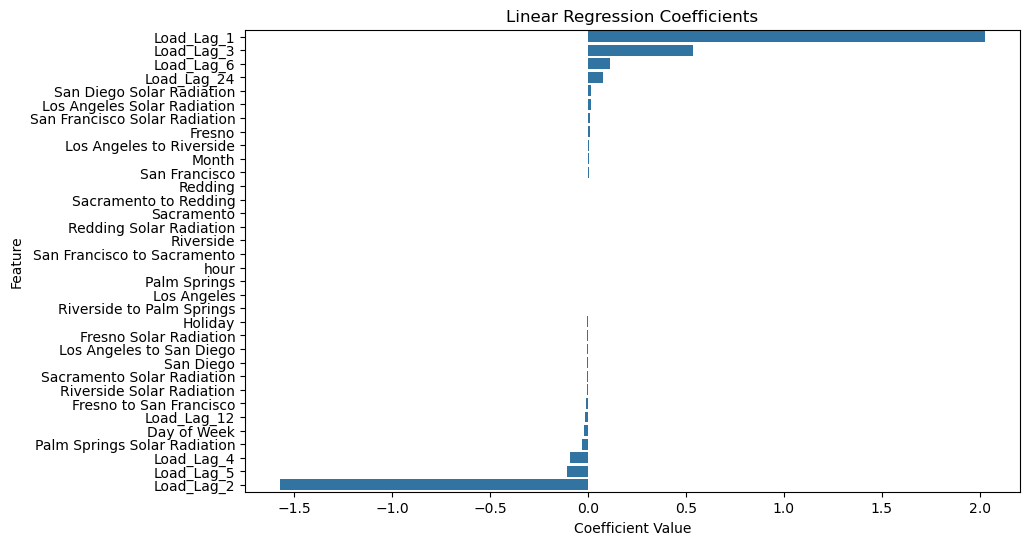

In [25]:
#plot weights of the linear regression model
import matplotlib.pyplot as plt
# Get the coefficients from the linear regression model
coefficients = linear_model.coef_
# Create a DataFrame for the coefficients
coefficients_df = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'Coefficient': coefficients
}).sort_values(by='Coefficient', ascending=False)
# Plot the coefficients
plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=coefficients_df)
plt.title('Linear Regression Coefficients')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.show()

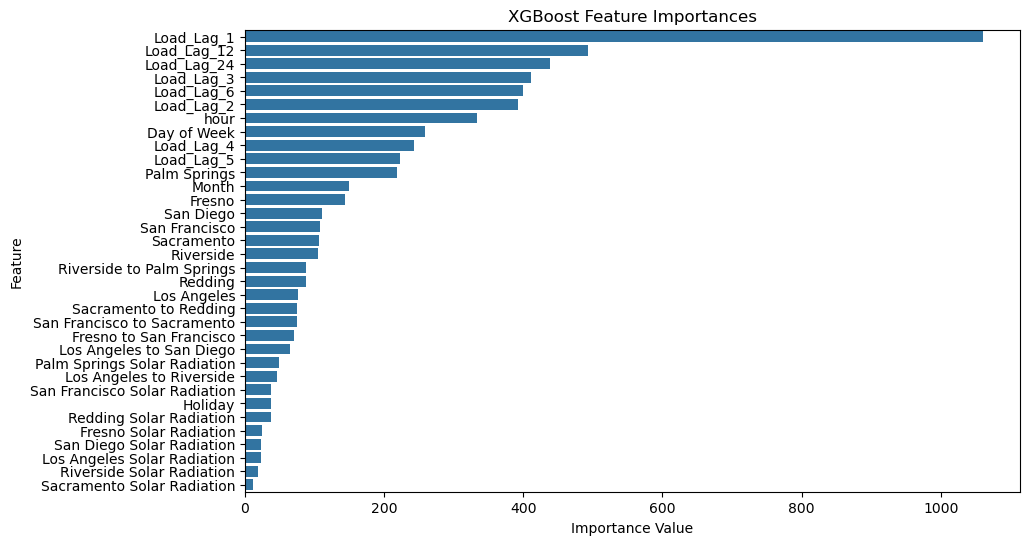

In [26]:
#Now let's compare the feature importances from XGBoost 

# Get feature importances from the XGBoost model
importances_xgb = xgb_model_lagged.get_score(importance_type='weight')
# Create a DataFrame for feature importances
importances_xgb_df = pd.DataFrame({
    'Feature': list(importances_xgb.keys()),
    'Importance': list(importances_xgb.values())
}).sort_values(by='Importance', ascending=False)
# Plot feature importances from XGBoost
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importances_xgb_df)
plt.title('XGBoost Feature Importances')
plt.xlabel('Importance Value')
plt.ylabel('Feature')
plt.show()

Polynomial Regression Mean Absolute Error (original units): 354.10858982639184


Error per Prediction for Polynomial Regression (original units):
[149.18829953 304.01141793 289.6405073  122.57305026 187.57217744]
Error Percentage per Prediction for Polynomial Regression:
[0.72948849 1.41744582 1.25243631 0.49582394 0.7485222 ]
Average Error Percentage per Prediction for Polynomial Regression: 1.5341185107196147%


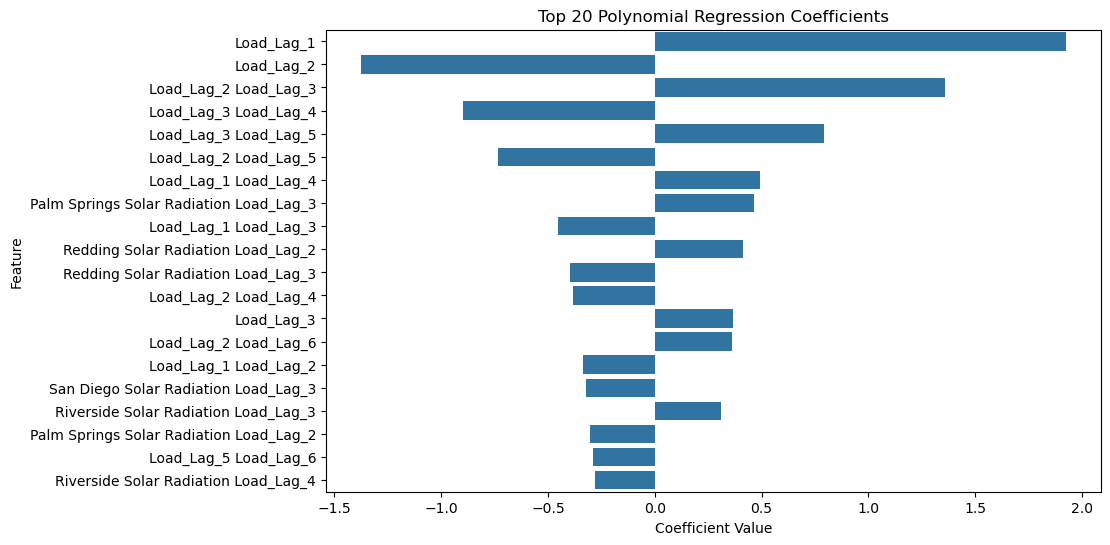

In [27]:
# Try a quadratic regression model and convert predictions back to original units before error investigation
from sklearn.preprocessing import PolynomialFeatures

# Create polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

# Create and fit the linear regression model for polynomial features
poly_linear_model = LinearRegression()
poly_linear_model.fit(X_train_poly, y_train_scaled)

# Predict on the test set with polynomial features
y_pred_poly = poly_linear_model.predict(X_test_poly)

# Inverse transform predictions and actuals to original units
y_pred_poly_orig = scaler.inverse_transform(y_pred_poly.reshape(-1, 1)).flatten()
y_test_poly_orig = scaler.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()

# Calculate the mean absolute error for polynomial regression in original units
mae_poly_orig = mean_absolute_error(y_test_poly_orig, y_pred_poly_orig)
print(f"Polynomial Regression Mean Absolute Error (original units): {mae_poly_orig}")

# Prepare DataFrame for plotting with polynomial regression predictions in original units
plot_df_poly_orig = pd.DataFrame({
    'Actual Load': y_test_poly_orig,
    'Predicted Load': y_pred_poly_orig,
    'Time': load_df.loc[y_test_lagged.index, 'Time'].values
})

fig_poly_orig = px.line(
    plot_df_poly_orig.sort_values('Time'),
    x='Time',
    y=['Actual Load', 'Predicted Load'],
    title='Polynomial Regression Predicted vs Actual Load Over Time (Original Units)',
    labels={'value': 'Load', 'variable': 'Legend'}
)
fig_poly_orig.show()

# Calculate the error for polynomial regression predictions in original units
error_per_prediction_poly_orig = np.abs(y_test_poly_orig - y_pred_poly_orig)
average_error_per_prediction_poly_orig = np.mean(error_per_prediction_poly_orig)
print("Error per Prediction for Polynomial Regression (original units):")
print(error_per_prediction_poly_orig[:5])

# Calculate error percentage for polynomial regression predictions
error_percentage_poly = (error_per_prediction_poly_orig / y_test_poly_orig) * 100

print("Error Percentage per Prediction for Polynomial Regression:")
print(error_percentage_poly[:5])
print(f"Average Error Percentage per Prediction for Polynomial Regression: {np.mean(error_percentage_poly)}%")
#plot the polynomial regression coefficients
# Get the coefficients from the polynomial regression model
coefficients_poly = poly_linear_model.coef_
# Create a DataFrame for the coefficients
coefficients_poly_df = pd.DataFrame({
    'Feature': poly.get_feature_names_out(X_train_scaled.columns),
    'Coefficient': coefficients_poly
}).sort_values(by='Coefficient', ascending=False)
# Show only the top 20 coefficients by absolute value
top_coefficients_poly_df = coefficients_poly_df.reindex(coefficients_poly_df['Coefficient'].abs().sort_values(ascending=False).index).head(20)
# Plot the top 20 coefficients for polynomial regression
plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=top_coefficients_poly_df)
plt.title('Top 20 Polynomial Regression Coefficients')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.show()


In [28]:
# Convert polynomial regression errors back to original units before error analysis

# Calculate error in original units
error_per_prediction_poly_orig = np.abs(y_test_poly_orig - y_pred_poly_orig)

# Remove outliers (more than 5 standard deviations from the mean)
mean_poly_orig = np.mean(error_per_prediction_poly_orig)
std_poly_orig = np.std(error_per_prediction_poly_orig)
mask = np.abs(error_per_prediction_poly_orig - mean_poly_orig) <= 5 * std_poly_orig
filtered_poly_errors_orig = error_per_prediction_poly_orig[mask]
average_filtered_poly_error_orig = np.mean(filtered_poly_errors_orig)
print(f"Average Error per Prediction for Polynomial Regression (filtered, original units): {average_filtered_poly_error_orig}")

# Calculate the error percentage for polynomial regression predictions after filtering outliers (original units)
filtered_poly_error_percentage_orig = (filtered_poly_errors_orig / y_test_poly_orig[mask]) * 100

px.line(
    x=plot_df_poly_orig['Time'][mask],
    y=filtered_poly_error_percentage_orig,
    title='Error Percentage per Prediction for Polynomial Regression (filtered, original units)',
    labels={'x': 'Time', 'y': 'Error Percentage (%)'}
).show()

print("Error Percentage per Prediction for Polynomial Regression (filtered, original units):")
print(filtered_poly_error_percentage_orig[:5])
print(f"Average Error Percentage per Prediction for Polynomial Regression (filtered, original units): {np.mean(filtered_poly_error_percentage_orig)}%")

Average Error per Prediction for Polynomial Regression (filtered, original units): 350.30272949052664


Error Percentage per Prediction for Polynomial Regression (filtered, original units):
[0.72948849 1.41744582 1.25243631 0.49582394 0.7485222 ]
Average Error Percentage per Prediction for Polynomial Regression (filtered, original units): 1.5167418609090688%


Polynomial Regression Mean Absolute Error (degree 2, original units): 374.94446504507516
Polynomial Regression Mean Absolute Error (degree 3, original units): 355.11248794101226
Polynomial Regression Mean Absolute Error (degree 4, original units): 370.1213281603919


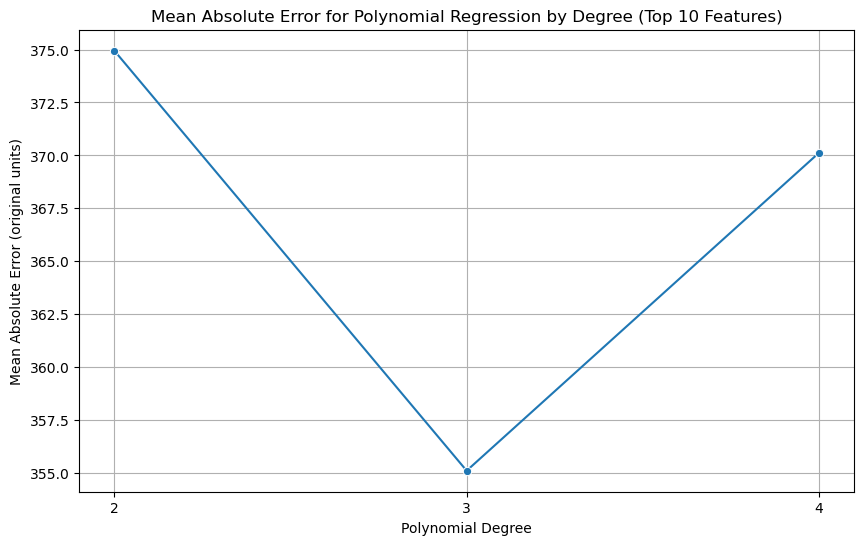

In [29]:
from sklearn.feature_selection import SelectKBest, f_regression

# Select top 10 features by univariate regression test
selector = SelectKBest(f_regression, k=10)
X_train_top = selector.fit_transform(X_train_scaled, y_train_scaled)
X_test_top = selector.transform(X_test_scaled)

n_values = range(2, 5)  # Limit to degree 2-4
mae_values = []

for n in n_values:
    poly = PolynomialFeatures(degree=n, include_bias=False)
    X_train_poly = poly.fit_transform(X_train_top)
    X_test_poly = poly.transform(X_test_top)

    poly_linear_model = LinearRegression()
    poly_linear_model.fit(X_train_poly, y_train_scaled)
    y_pred_poly = poly_linear_model.predict(X_test_poly)

    y_pred_poly_orig = scaler.inverse_transform(y_pred_poly.reshape(-1, 1)).flatten()
    y_test_poly_orig = scaler.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()

    mae_poly_orig = mean_absolute_error(y_test_poly_orig, y_pred_poly_orig)
    mae_values.append(mae_poly_orig)
    print(f"Polynomial Regression Mean Absolute Error (degree {n}, original units): {mae_poly_orig}")

plt.figure(figsize=(10, 6))
sns.lineplot(x=n_values, y=mae_values, marker='o')
plt.title('Mean Absolute Error for Polynomial Regression by Degree (Top 10 Features)')
plt.xlabel('Polynomial Degree')
plt.ylabel('Mean Absolute Error (original units)')
plt.xticks(n_values)
plt.grid()
plt.show()

In [32]:
#save polynomial regression model
import joblib
# Save the polynomial regression model and scaler
joblib.dump(poly_linear_model, '../../models/polynomial_regression_model.pkl')
joblib.dump(scaler, '../../models/polynomial_regression_scaler.pkl')
# Save the polynomial features transformer
joblib.dump(poly, '../../models/polynomial_features_transformer.pkl')
# Save the feature selector
joblib.dump(selector, '../../models/feature_selector.pkl')


['../../models/feature_selector.pkl']